# Pulse-Based Large Variational Quantum Algorithm for Combinatorial Optimization Problems - Draft 2

Ohad Lev

April 2024

## 1. Online Generation of (Deterministic) Graph Instances

Last time we talked about employing modular arithmetic for this task, but we saw that the scheme I proposed didn't fit: consider the function $f(x, n) = x + 2 \mod n$. then $f(3, 7) = 3 + 2 \mod 7 = 5$, but $f(5, 7) = 5 + 2 \mod 7 = 0$. So, the generation function is not deterministic.

We can employ even a simpler scheme that might fit:

0 {9}
1 {8, 9}
2 {8, 9, 7}
3 {8, 6, 7}
4 {5, 6, 7}
5 {4, 6}
6 {3, 4, 5}
7 {2, 3, 4}
8 {1, 2, 3}
9 {0, 1, 2}


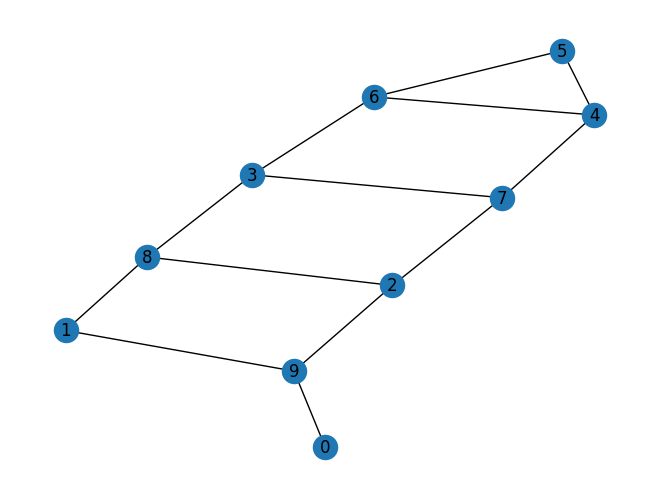

In [34]:
import networkx as nx

def obtain_adjacent_nodes(node_index: int, num_total_nodes: int) -> set[int]:
        
    if node_index == 0:
        adj_nodes = {num_total_nodes - 1 - node_index}
    
    elif node_index == 1:
        adj_nodes = {num_total_nodes - node_index, num_total_nodes - 1 - node_index}
    
    else:
        adj_nodes = {
            num_total_nodes - node_index,
            num_total_nodes - 1 - node_index,
            num_total_nodes + 1 - node_index
        }
    
    if node_index in adj_nodes:
        adj_nodes.remove(node_index)
    
    return adj_nodes

num_nodes = 10

graph_structure = {}
for i in range(num_nodes):
    adj_nodes = obtain_adjacent_nodes(i, num_nodes)
    graph_structure[i] = adj_nodes
    
    print(i, adj_nodes)

nx.draw(nx.Graph(graph_structure), with_labels=True)

This scheme generates what we need. However, similar to before, I am not sure if those kinds of generation schemes make the problem at hand easier (trivial?) to solve.

------------

## 2. Verification of Solutions

Assume we have an efficient online generation scheme of graph instances. In addition, assume we have a solution at hand, even if it's a random solution. In the exponentially large problem-settings we look for, it's exponentially hard even to compute the cut of a given partition vector. The verification process is linear in the number of nodes $O(|V|)$, but the number of nodes is exponential in the number of qubits $|V| = O(2^n)$, so the verification process is exponentially hard in the number of qubits $n$. So this kind of "naive" setting won't work.

However, we did discuss in the past about a sub-problem of MaxCut, called **$(k, n-k)$-MaxCut** [[1]](#References), or using our notation **$(B, |V| - B)$-MaxCut** problem. In [[1]](#References), an algorithm is presented (and claimed to be the best one) to solve the decision version of this problem in $O^*(2^p)$ time, where $p$ is the size of the cut (and $O^*$ indicates an omission of polynomial and sub-polynomial factors). Typically, $p$ can be (much?) smaller than $|V|$. However, I think that it's plausible to assume that $p \approx O(B)$ or even $p \approx \Omega(B)$ if we choose $B << |V|$, but we will have to prove this. My intuition tells me that if we set $|V| = 2^{60}$ and $B = 512$, then a maximum cut will be obtained by choosing $512$ nodes that are connected with at least one edge to the other $2^{60} - 512$ nodes.

However, this kind of task seems very easy to me, so I can't understand the claimed exponential complexity. Just pick at random $512$ nodes, and you will probably obtain an optimal, or near-optimal solution.

On second thought, that might be the case for regular graphs only. In a non-regular graph with $B << |V|$, my intuition tells me to pick non-adjacent high-degree nodes as the blue ones. But if we don't know the degree of the vertices a priori, then this task might be hard. So I guess we will have to cook a more sophisticated method for the online generation of our graph-instances, since the current method presented above produces almost-regular graphs.

Anyway, to verify a solution we need only $O(B)$ time, if the degrees of the vertices are constant numbers. By choosing a constant $B \approx O(1)$ or even $B \approx O(\text{polylog}(|V|)$, this should be easy. E.g. when $n = 60$, $|V| = 2^{60}$, we can choose $B = 60^2 = 3600$. This order of $B$ is intractable for exponentially (in $B$) costly algorithms (like we think [[1]](#References) is), but very easy for algorithms that are linear in $B$ (like the verification process is).

-------------------

## 3. Encoding

Our encoding has to be logarithmic in the graph size, otherwise the whole idea is pointless. For now, we stick with a node-to-basis-state encoding, although it might be beneficial to consider other methods, like an edge-to-basis-state encoding, for example.

------------

## 4. Ansatz

We will probably employ a pulsified, heuristic Ansatz - but for now, I don't discuss this yet.

----------

## 5. Objective Function

If anything else works fine, then crafting a suitable objective function for our algorithm remains the most problematic issue, in my opinion. The solutions space, by construction, is huge ($ > 2^{50}$). We can't afford the objective function to "play" in this scale.

What I think it means, is that in order to obtain an effective cost function, we will have to go through a process of trying many heuristics to see which methods are beneficial. I think that digging into deep-learning techniques might be worthy in this context, as these techniques were created to tackle huge non-convex optimization problems. To my understanding, many deep-learning techniques evolved through highly heuristic, trial-and-error processes.

A Few options that come to my mind:

### 5.A QEMC Style:

Let $f(x)$ be the function that returns the set of adjacent nodes to the node $x \in V$, then we can minimize the following loss function:

$$
    L(P) = \sum_{p_i \in P} \sum_{j \in f(i)}
    \bigg(p_i + p_j - \frac{1}{B} \bigg)^2 +
    \bigg(|p_i - p_j| - \frac{1}{B} \bigg)^2
$$

Where $P$ is the probability distribution obtained by measuring the Ansatz $S$ (TBD how many shots $S$) times, and $p_x \in P$ is the probability associated with node $x$.

**Pros:**

* We iterate only over $O(S)$ nodes. If $S = O(\text{poly} B)$, then we are good.
* A similar loss function was shown to be effective when employed for the original QEMC algorithm.

**Cons:**

* We consider $B$ values that are tiny fractions of $|V|$ (e.g., $3600 / 2^{60} \approx 10^{-15}$). I think we have no feasible chance of success when starting from a random guess. Maybe there is a more clever way to begin with.

### 5.B Deviating From the Randomized Expected Value

Having $B$ blue nodes out of $|V|$ total nodes, makes the chance of a node $j$ adjacent to node $i$ to be of the same color as $1 - B / |V|$, and of different colors as $B / |V|$. So, if we guess $B$ nodes as blue nodes at random, we should expect to obtain the following (averaged over several cases) cut:

$$
    \mathbb{E}[X] = \frac{B}{|V|}
$$

Where $X$ is the random variable that holds the cuts of random partitions. So, we can propose to minimize the following loss function:

$$
    L(P) = - \bigg( c(P) - \frac{B}{|V|} \bigg) = \frac{B}{|V|} - c(P)
$$

Where $c(P)$ is the cut obtained by coloring nodes associated with the $B$ largest probabilities in $P$ as blue nodes, and computing the cut.

### 5.C Deviating From the Uniform Distribution

Following a similar logic (but different) as explained in [Section 5.B](#5.B-Deviating-From-the-Randomized-Expected-Value), we can think that obtaining a uniform distribution upon measuring the Ansatz is an undesired, meaningless result. Inspired by machine-learning techniques, maybe we can employ statistical tools such as distances between probability distributions for our cause.

**TO BE CONTINUED**

---------------

## References

[[1]](https://link.springer.com/article/10.1007/s00453-018-0418-5) Saurabh, Saket, and Meirav Zehavi. "**$(k, n-k)$-Max-Cut: An $O^*(2^ p)$-Time Algorithm and a Polynomial Kernel.**" Algorithmica 80 (2018): 3844-3860.